# MonReader
---
## Summary

**Data Description:**

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

**Goal(s):**

Predict if the page is being flipped using a single image.

**Success Metrics:**

Evaluate model performance based on F1 score, the higher the better.

**Bonus(es):**

Predict if a given sequence of images contains an action of flipping.


# Setup

## Import Libraries

In [31]:
# Standards
import os
import re
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
import statistics
import tensorflow as tf

# For Data Import
from pathlib import Path
from collections import defaultdict

# For Model
from keras.models import Sequential, load_model
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from sklearn.metrics import classification_report
from keras import backend as K

# For Prediction Model
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.metrics import Precision, Recall, AUC
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.sequence import pad_sequences
from tensorflow.data import Dataset


# Warnings
import warnings

# Suppress deprecation warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=UserWarning)

## Import Data

Image data should be preprocessed before feeding into a computer vision model. Here, we've included normalization and resizing of the data.

In [3]:
# Define the pre-processing functions
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

# Get image paths and labels for training and testing datasets
def get_image_paths_and_labels(directory):
    flip_image_paths = [str(path) for path in list(Path(directory + '/flip').glob('*.jpg'))]
    notflip_image_paths = [str(path) for path in list(Path(directory + '/notflip').glob('*.jpg'))]
    flip_labels = [1]*len(flip_image_paths)
    notflip_labels = [0]*len(notflip_image_paths)
    return flip_image_paths + notflip_image_paths, flip_labels + notflip_labels

# Folder paths
training_folder_path = r"C:\ref\images\training"
testing_folder_path = r"C:\ref\images\testing"


train_image_paths, train_image_labels = get_image_paths_and_labels(training_folder_path)
test_image_paths, test_image_labels = get_image_paths_and_labels(testing_folder_path)

batch_size = 32 # Define batch size

# Create Datasets
train_path_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
train_image_label_ds = train_path_ds.map(load_and_preprocess_from_path_label)
train_ds = train_image_label_ds.shuffle(buffer_size=len(train_image_labels)).batch(batch_size)

test_path_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_image_labels))
test_image_label_ds = test_path_ds.map(load_and_preprocess_from_path_label)
test_ds = test_image_label_ds.shuffle(buffer_size=len(test_image_labels)).batch(batch_size)


# Data Exploration

In [5]:
# Create functions that validate that the files are as expected.

def check_filenames(folder):
    """
    Check if all filenames in a folder follow the expected format: VideoID_FrameNumber.jpg
    """
    for root, _, files in os.walk(folder):
        for file in files:
            if not re.fullmatch(r'\d+_\d+\.jpg', file):
                print(f'Unexpected filename format: {os.path.join(root, file)}')


def count_files_in_folders(main_folder):
    """
    Count files in each subfolder within the main folder.
    """
    for folder_name in ['flip', 'notflip']:
        folder_path = os.path.join(main_folder, folder_name)
        
        if os.path.exists(folder_path):
            num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            print(f"Number of files in '{folder_name}' subfolder: {num_files}")
        else:
            print(f"'{folder_path}' does not exist.")

# Check filenames in training and validation folders
print("Filename validation check:")
check_filenames(training_folder_path)
check_filenames(testing_folder_path)
print("-------------")

# Check the number of files in 'flip' and 'notflip' subfolders in training and validation folders
print("File count validation check:")
print(f"{training_folder_path}")
count_files_in_folders(training_folder_path)
print(f"{testing_folder_path}")
count_files_in_folders(testing_folder_path)
print("-------------")

Filename validation check:
-------------
File count validation check:
C:\ref\images\training
Number of files in 'flip' subfolder: 1162
Number of files in 'notflip' subfolder: 1230
C:\ref\images\testing
Number of files in 'flip' subfolder: 290
Number of files in 'notflip' subfolder: 307
-------------


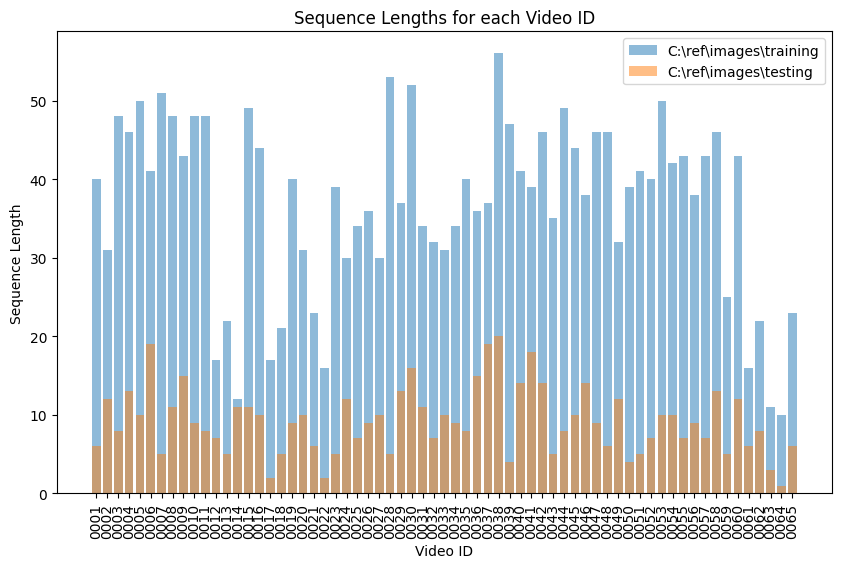

In [6]:
# Explore the length of the videos
# Sum sequence lengths for all video IDs in a given folder
def check_sequence_lengths(base_folder):
    """Check sequence lengths for all video IDs and return their sum."""
    # Create a dictionary to hold the number of frames for each video ID
    video_lengths = defaultdict(int)
    
    labels = ['flip', 'notflip']  # Define the labels
    for label in labels:  # Iterate over each label
        folder = os.path.join(base_folder, label)  # Form the complete path
        files = os.listdir(folder)
        
        # Count the number of frames for each video
        for file in files:
            video_id, _ = os.path.splitext(file)[0].split("_")
            video_lengths[video_id] += 1
            
    # Sum the lengths of all videos
    total_length = sum(video_lengths.values())
    
    return video_lengths, total_length

# Check the length of each video
def plot_sequence_lengths(folders):
    """Check sequence lengths for all video IDs in multiple folders and plot them."""
    plt.figure(figsize=(10, 6))
    
    for folder in folders:
        video_lengths, _ = check_sequence_lengths(folder)
        
        # Plot the sequence lengths for this folder
        plt.bar(video_lengths.keys(), video_lengths.values(), alpha=0.5, label=folder)

    plt.xlabel('Video ID')
    plt.ylabel('Sequence Length')
    plt.title('Sequence Lengths for each Video ID')
    plt.xticks(rotation=90)  # Rotate the x-axis labels for readability
    plt.legend()  # Add a legend to differentiate between folders
    plt.show()

plot_sequence_lengths([training_folder_path, testing_folder_path])

### Observations

- The sequence lengths vary from video to video. This means that not every video is the same length, and thus we are testing and training on variable amounts of information per video. This will need to be considered when predicting videos as a whole.
- In general, the video lengths in the testing set are shorter than in the training set. 

# Modelling

## Setup

In [33]:
# Define a CNN model

model = Sequential() # Base liner layer model
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3))) # 1st layer
model.add(MaxPooling2D((2, 2))) # Reduce size of convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu')) # 2nd layer
model.add(MaxPooling2D((2, 2))) # Reduce size of convolutional layer
model.add(Flatten()) # Convert to vector for dense layers
model.add(Dense(64, activation='relu')) # 3rd layer - dense
model.add(Dense(1, activation='sigmoid')) # Output Binary layer: flip or not flip


## Evaluation

In [34]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

# fit the model
history = model.fit(train_ds, epochs=5, validation_data=test_ds)

# evaluate the model
loss, accuracy, precision, recall, f1_score = model.evaluate(test_ds)


Epoch 1/5
75/75 [==============================] - 107s 1s/step - loss: 0.7984 - accuracy: 0.6856 - precision_m: 0.6759 - recall_m: 0.6319 - f1_m: 0.6145 - val_loss: 0.3751 - val_accuracy: 0.8476 - val_precision_m: 0.7714 - val_recall_m: 0.9795 - val_f1_m: 0.8590
Epoch 2/5
75/75 [==============================] - 99s 1s/step - loss: 0.1790 - accuracy: 0.9348 - precision_m: 0.9406 - recall_m: 0.9329 - f1_m: 0.9294 - val_loss: 0.1881 - val_accuracy: 0.9397 - val_precision_m: 0.9934 - val_recall_m: 0.8770 - val_f1_m: 0.9293
Epoch 3/5
75/75 [==============================] - 102s 1s/step - loss: 0.0782 - accuracy: 0.9745 - precision_m: 0.9748 - recall_m: 0.9707 - f1_m: 0.9715 - val_loss: 0.1136 - val_accuracy: 0.9631 - val_precision_m: 0.9360 - val_recall_m: 0.9880 - val_f1_m: 0.9603
Epoch 4/5
75/75 [==============================] - 102s 1s/step - loss: 0.0397 - accuracy: 0.9849 - precision_m: 0.9840 - recall_m: 0.9838 - f1_m: 0.9831 - val_loss: 0.0604 - val_accuracy: 0.9765 - val_precisi

### Observations

We find that a general CNN prediction model scores highly for all metrics including accuracy, precision, recall, and F1 score.

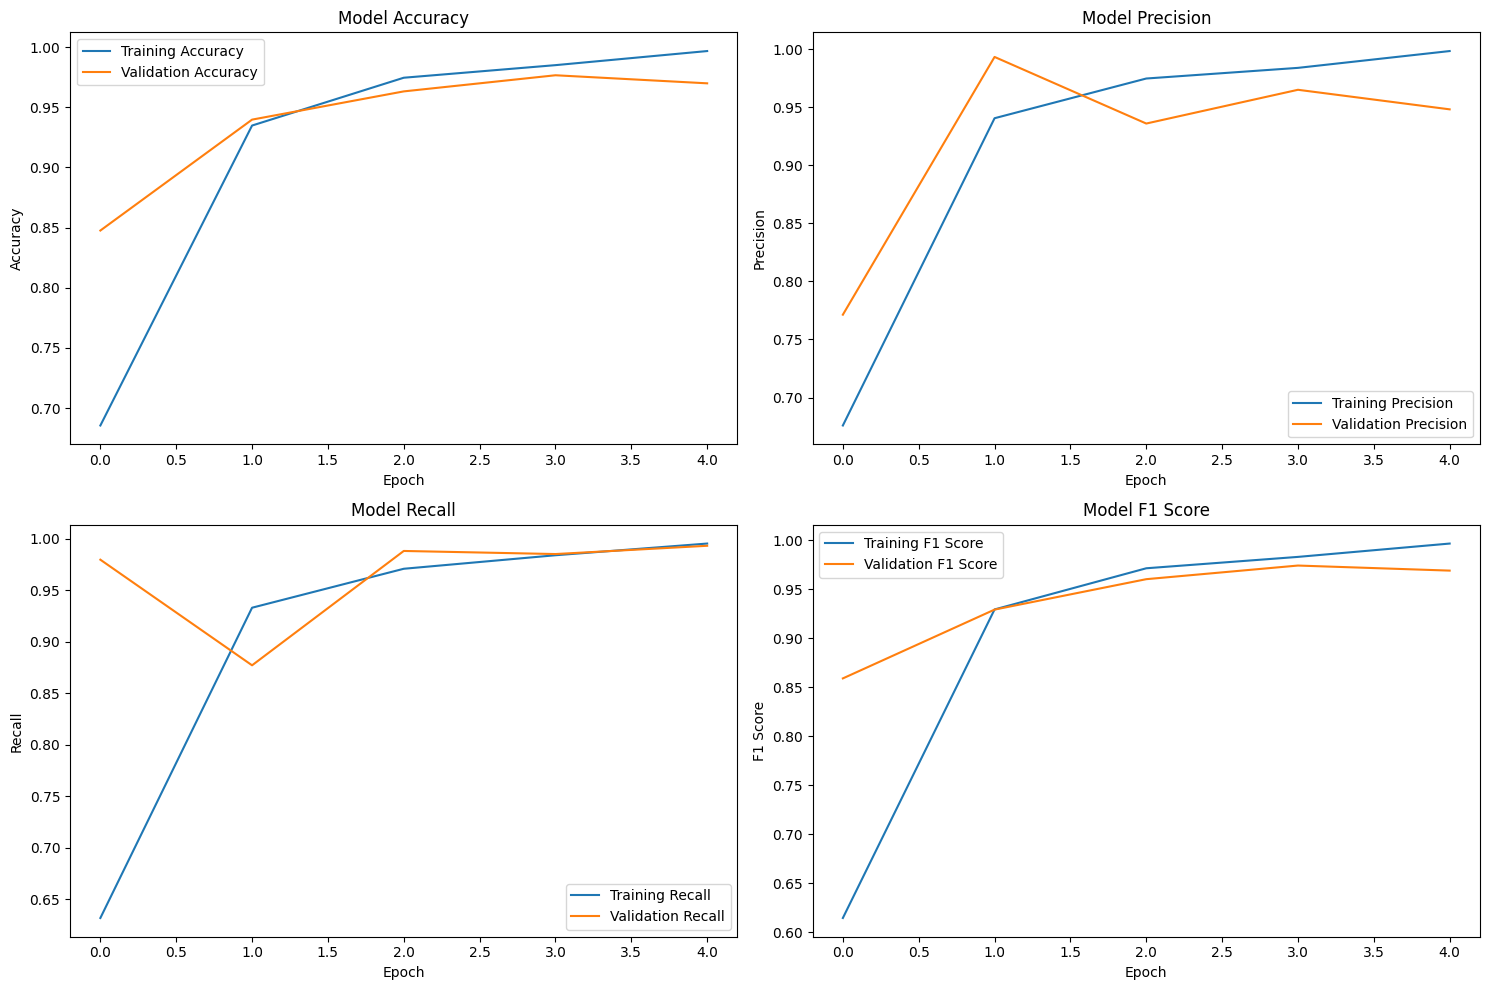

In [35]:
# Define the figure
plt.figure(figsize=(15,10))

# Define the subplot for accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Define the subplot for precision
plt.subplot(2, 2, 2)
plt.plot(history.history['precision_m'], label='Training Precision')
plt.plot(history.history['val_precision_m'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend()

# Define the subplot for recall
plt.subplot(2, 2, 3)
plt.plot(history.history['recall_m'], label='Training Recall')
plt.plot(history.history['val_recall_m'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()

# Define the subplot for f1 score
plt.subplot(2, 2, 4)
plt.plot(history.history['f1_m'], label='Training F1 Score')
plt.plot(history.history['val_f1_m'], label='Validation F1 Score')
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


## Bonus

Predict if a given sequence of images contains an action of flipping.

In [40]:
# Define the directory where your images are stored
image_dir = r"C:\ref\images\testing"

# Subdirectories ('flip' and 'notflip')
subdirs = ['flip', 'notflip']

# Dictionary to store predictions
predictions = {'flip': [], 'notflip': []}

# Iterate over each subdir
for subdir in subdirs:
    subdir_path = os.path.join(image_dir, subdir)
    
    # Iterate over images in directory
    for file in os.listdir(subdir_path):
        # Load the image file
        img = image.load_img(os.path.join(subdir_path, file), target_size=(224, 224))
        
        # Convert the image to a numpy array and normalize
        img_tensor = image.img_to_array(img)  # shape is (224, 224, 3)
        img_tensor = np.expand_dims(img_tensor, axis=0)  # shape is (1, 224, 224, 3)
        img_tensor /= 255.  # model was trained on inputs normalized to [0,1]

        # Pass the image through the model and get the prediction
        prediction = model.predict(img_tensor)
        
        # Store prediction
        predictions[subdir].append(prediction)


1/1 [==============================] - 0s 38ms/step


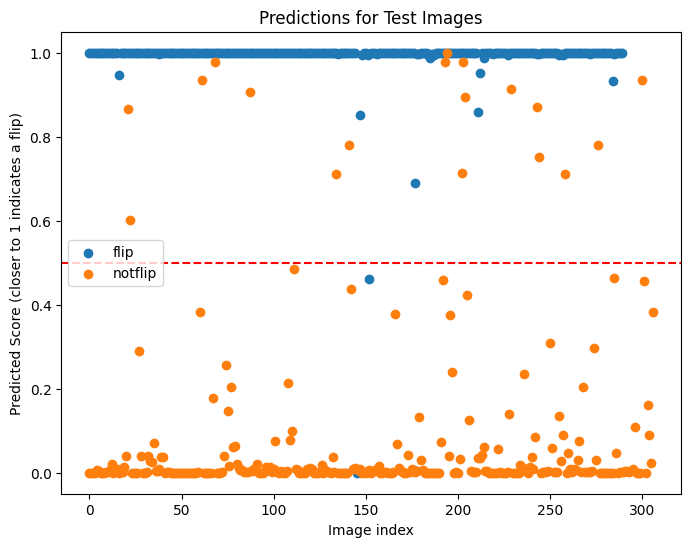

In [37]:
# Create a new figure
plt.figure(figsize=(8, 6))

# Plot the predictions for each subdirectory
for subdir, subdir_predictions in predictions.items():
    plt.scatter(range(len(subdir_predictions)), [pred[0][0] for pred in subdir_predictions], label=subdir)

# Add a horizontal line at 0.5 (our decision boundary)
plt.axhline(y=0.5, color='r', linestyle='--')

# Add labels and a legend
plt.title('Predictions for Test Images')
plt.xlabel('Image index')
plt.ylabel('Predicted Score (closer to 1 indicates a flip)')
plt.legend()

# Show the plot
plt.show()

# Summary

Above, the 'notflip' points (indicated by orange dots) should be closer to zero, indicating a 'notflip'. The same is true in opposite for the 'flip' and blue dots.

This indicates visually, in addition to the numerical metrics above, that the model is fairly capable of identifying a flip given a series of images.

# Appendix: Time-Dependant Prediction

Here, we will address predicting a flip from a given complete video. 

This task is more complex than image classification for a couple of reasons. First, the model now has to understand the time-relationship between images in a sequence. Second, the model also has to be able to understand the concept of the "flipping" action, which involves more than just the static content of a single image.

For these reasons, we will look at using a Long Short-Term Memory (LSTM) network to analyze the sequence of images and predict if a page flip action is occurring. 

## Prepare Data

Here we prepare functions that will get and preprocess the images when called. 

All frames from a single video were grouped together in a dictionary where the key was the video ID and the value was a list of frames. Each frame was resized to 224x224 and normalized to a range [0,1]. The frames were sorted according to their sequence in the video.

In [10]:
# Similar to previous function

# Define the pre-processing functions and get images
def load_and_sort_frames(flip_folder, notflip_folder):
    # Load all images
    all_images = {}
    labels = {}
    for folder in [flip_folder, notflip_folder]:
        label = 1 if folder == flip_folder else 0  # Assign label based on folder
        for filename in os.listdir(folder):
            # The filename format is VideoID_FrameNumber.jpg
            videoid, frameno_with_ext = filename.split('_')
            frameno, ext = frameno_with_ext.split('.')
            frameno = int(frameno)
            img = cv2.imread(os.path.join(folder, filename))
            img = cv2.resize(img, (224, 224))
            img = img / 255.0
            if videoid not in all_images:
                all_images[videoid] = []
                labels[videoid] = label  # Assign label to this video
            all_images[videoid].append((frameno, img))
    
    # Sort frames for each video
    for videoid in all_images:
        all_images[videoid].sort(key=lambda x: x[0])  # Sort by frame number
        all_images[videoid] = [x[1] for x in all_images[videoid]]  # Remove frame number

    return all_images, labels


## Model

### Define Model

For each bucket, a separate model was trained. The model consisted of a Convolutional Neural Network (CNN) followed by a Long Short-Term Memory (LSTM) network. The CNN extracted spatial features from each frame, while the LSTM captured temporal dependencies between the frames. The output of the LSTM was passed to a Dense layer for binary classification. Each model was trained only on the sequences within its corresponding bucket. After training, the models were saved to disk.

In [11]:
def train_model(bucketed_data):
    models = {}
    for bucket_size in bucketed_data:
        print(f"Training on bucket {bucket_size}:")
        
        bucket_data = bucketed_data[bucket_size]
        
        # Define the model for this bucket
        model = Sequential()
        model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(bucket_size, 224, 224, 3)))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(32))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(), Recall()])

        for data in bucket_data:
            x, y = data
            x = np.expand_dims(x, axis=0)  # Add an extra dimension
            y = np.array([y])  # Convert y to numpy array
            model.fit(x, y, epochs=5, batch_size=32)

        # Save the model after training
        model_path = f"model_{bucket_size}.h5"
        model.save(model_path)
        models[bucket_size] = model_path

    return models

### Train Model

In [12]:
# Load, bucket, and pad videos
flip_folder = r"C:\ref\images\training\flip"
notflip_folder = r"C:\ref\images\training\notflip"
all_images, labels = load_and_sort_frames(flip_folder, notflip_folder)

bucket_sizes = [10, 20, 30, 40, 50, 60]
bucketed_data = {}
for size in bucket_sizes:
    bucketed_data[size] = []

for videoid in all_images:
    video_frames = all_images[videoid]
    bucket_size = min(max(bucket_sizes), len(video_frames), key=lambda x:abs(x-len(video_frames)))
    
    # Add an extra dimension to video_frames and pad
    video_frames = [video_frames]  # Add extra dimension
    padded_frames = pad_sequences(video_frames, maxlen=bucket_size, dtype='float32')
    
    # Remove the extra dimension from padded_frames
    padded_frames = padded_frames[0]  # Remove extra dimension

    # Assuming you have your labels in a dictionary with video ID as key
    label = labels[videoid]

    if bucket_size not in bucketed_data:
        bucketed_data[bucket_size] = []
    bucketed_data[bucket_size].append((padded_frames, label))

models = train_model(bucketed_data)


Training on bucket 10:
Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.7111 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 926ms/step - loss: 0.2076 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 3/5
1/1 [==============================] - 1s 940ms/step - loss: 0.1903 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 4/5
1/1 [==============================] - 1s 952ms/step - loss: 0.1757 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 5/5
1/1 [==============================] - 1s 950ms/step - loss: 0.1617 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000


c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training on bucket 20:
Training on bucket 30:
Epoch 1/5
1/1 [==============================] - 6s 6s/step - loss: 0.6636 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 0.0891 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 0.0810 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 0.0737 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 0.0669 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.0607 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 0.0550 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
Epoch 3/5

### Test Model

For testing, we employed a similar bucketing strategy as we did for training, with different bucket sizes to match the length of the sequences in the test set. Each sequence was evaluated by the model that was trained on the bucket with the closest sequence length. The performance was evaluated in terms of loss, accuracy, precision, and recall.

In [13]:
# Load and preprocess the testing data
test_flip_folder = r"C:\ref\images\testing\flip"
test_notflip_folder = r"C:\ref\images\testing\notflip"
test_images, test_labels = load_and_sort_frames(test_flip_folder, test_notflip_folder)

print(f"test_images size: {len(test_images)}")
print(f"test_labels size: {len(test_labels)}")

# Define bucket sizes for the test set
test_bucket_sizes = [5, 10, 15, 20]

# Bucket and pad videos in the testing data
bucketed_test_data = {}
for size in test_bucket_sizes:
    bucketed_test_data[size] = []

for videoid in test_images:
    video_frames = test_images[videoid]
    bucket_size = min(test_bucket_sizes, key=lambda x:abs(x-len(video_frames)))

    # Add an extra dimension to video_frames and pad
    video_frames = [video_frames]  # Add extra dimension
    padded_frames = pad_sequences(video_frames, maxlen=bucket_size, dtype='float32')
    
    # Remove the extra dimension from padded_frames
    padded_frames = padded_frames[0]  # Remove extra dimension

    # Get the label for this video
    label = test_labels[videoid]

    bucketed_test_data[bucket_size].append((padded_frames, label))


test_images size: 65
test_labels size: 65


In [14]:
# For each bucket size
for bucket_size in bucketed_test_data:
    print(f"Evaluating on bucket {bucket_size}:")
    
    # Get the data for this bucket size
    bucket_data = bucketed_test_data[bucket_size]
    
    # Check if we have a model for this bucket size
    if bucket_size not in models:
        print(f"No model trained for bucket size {bucket_size}")
        continue
    
    model_path = models[bucket_size]  # Get the model path for this bucket size
    model = load_model(model_path)  # Load the model from the saved path
    
    # For each video in the bucket
    for x, y in bucket_data:
        x = np.expand_dims(x, axis=0)
        y = np.array([y])
        
        # Evaluate the model on this video
        loss, accuracy, precision, recall = model.evaluate(x, y, verbose=0)
        
        print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")


Evaluating on bucket 5:
No model trained for bucket size 5
Evaluating on bucket 10:
Loss: 0.14881999790668488, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.14881999790668488, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.14881999790668488, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.14881999790668488, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.14881999790668488, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.14881999790668488, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.14881999790668488, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.14881999790668488, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.14881999790668488, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.14881999790668488, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.14881999790668488, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.14881999790668488, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.14881999790668488, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 

## Observations

The accuracy metrics values are suspiciously high and consistent. Although this cause of this hasn't been fully determined, this section will remain here as an interesting problem, and as a basis for potential future work.